# Heat Equation

This notebook implements the PIGP and PSGP experiments involving the heat equation from Section 4.3 of the manuscript

## Preliminaries 

Whether to run computations on GPU or CPU

In [1]:
import os

USE_GPU: bool = True

if not USE_GPU:
    os.environ["JAX_PLATFORM_NAME"] = "cpu"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [2]:
import jax.numpy as jnp
from jax import config, random

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys
sys.path.append("../../")

import jax_pigp
from jax_pigp.utility_fns import (
    softplus,
    generate_params,
    PARAM_OPTIONS_DICT as param_gen_options,
)
from jax_pigp.base import Callable, Array

from utility_fns import *

# double precision prevents nans
config.update("jax_enable_x64", True)

### Specify settings of the experiments

Ensure that this cell is tagged as "parameters" if using [papermill](https://papermill.readthedocs.io/en/latest/)

In [3]:
# base random seed for parameter initialisation
BASE_SEED_VAL: int = 444

# true value of the heat parameter theta
THETA_TRUE: Array = jnp.array([1.0])

# initial value of theta from which to start training
THETA_INIT: Array = jnp.array([5.0])

# Set to true to consider inverse problem of identifying theta
RUN_INVERSE: bool = True

# index of randomly regenerated dataset - 5 are provided
RNG_INDEX: int = 0 # 0 <= RNG_INDEX <= 4

# whether to use a psgp or pigp, i.e. whether to incorporate symmetry information
# into the inference or not
GP_TYPE = "psgp"
assert GP_TYPE in ["pigp", "psgp"]

# number of u/f/g space observations to use for inference
N_DATA: int = 10
Nu: int = N_DATA
Nf: int = N_DATA
# for pigp, no ISC data is incorporated so Ng = 0 in this case
Ng: int = N_DATA if GP_TYPE == "psgp" else 0

# path to subdirectory in ./data where fisher-like equation data is saved
data_save_dir: str = f"heatEquation/heatData_rng_index_{RNG_INDEX}_noise_0.01"
data_save_dir_full = os.path.join("data", data_save_dir)
assert os.path.isdir(data_save_dir_full)

# dimensionality of the spatio-temporal domain (including time)
INPUT_DIM: int = 2

# initial value for std of noise levels in each space
NOISE_INIT: float = 0.1

# softplus transformation ensures noise and theta values are positive
THETA_TRANSFORM: Callable = softplus
NOISE_TRANSFORM: Callable = softplus

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = False

# options for model training
N_TRAIN_STEPS: int = 20000
N_RESTARTS: int = 3
LR_INIT: float = 0.005
VERBOSE: bool = False

### Specify mean and kernel functions

These are designed such that the GP exactly satisfies the initial condition at $t=0.5$ and lower spatial boundary condition at $x=0$

In [4]:
def phi(loc: Array):
    x, t = loc
    return x * (t - 0.5)


base_kernel = jax_pigp.kernels.rational_quadratic


def kernel_fn(params: dict, loc1: Array, loc2: Array):

    base_kernel_val = base_kernel(params, loc1, loc2)

    cov_val = phi(loc1) * phi(loc2) * base_kernel_val

    return cov_val.squeeze()


def mean_fn(params: dict, loc: Array):
    x, _ = loc
    return (2.0 * jnp.sqrt(2.0) * x * jnp.exp((-(x**2)) / 2.0)).squeeze()

### Specify linear differential operators

Recall that the heat PDE over one spatial dimension takes the form

$$PDE[u] =   \frac{\partial u}{\partial t} - \theta \frac{\partial^2 u}{\partial x^2} = f = 0,$$
where $\theta$ is the thermal diffusivity coefficient. In shorthand notation (see Eq.(25) of the paper), the PDE reads as

$$PDE[u] =  u_{t} - \theta u_{xx} = f = 0.$$

The ISC (see Eq.(27)) has the form

$$ ISC[u] =     \left(\frac{x^2}{4 \theta }+\frac{t}{2}\right) u+x t u_x+t^2 u_t = g = 0.$$

##### Implementation: 

* We define a dummy linear operator for $u$-space data which is just the identity transformation
* The PDE can be applied to a given function using ``apply_PDE`` defined below, and similarly the ISC can be applied using ``apply_ISC``


In [5]:
def apply_Identity(fn: Callable, argnum: int = 1):
    r"""
    Dummy identity transformation for u-space data
    """
    return fn


def apply_PDE(fn: Callable, argnum: int = 1):
    r"""
    Applies the Heat PDE to given input
    fn, evaluated at specified argnum
    """

    # the Jacobian and Hessian functions
    Jfn, Hfn = jac_hess(fn, argnum)

    def PDE(params: dict, loc1: Array, *loc2: Array):
        ## Note: we assume spatial value comes before temporal value in loc1 and loc2

        theta = THETA_TRANSFORM(params["theta"])[0] if RUN_INVERSE else THETA_TRUE[0]

        _, ut_val = Jfn(params, loc1, *loc2)

        uxx_val = Hfn(params, loc1, *loc2)[0, 0]

        return_val = ut_val - theta * uxx_val

        return return_val

    return PDE


def apply_ISC(fn: Callable, argnum: int = 1):
    r"""
    Applies the Heat ISC to given input
    fn, evaluated at specified argnum
    """

    # the Jacobian function
    Jfn, _ = jac_hess(fn, argnum)

    def ISC(params: dict, loc1: Array, *loc2: Array):
        ## Note: we assume spatial value comes before temporal value in loc1 and loc2

        x, t = loc1 if argnum == 1 else loc2[0]

        theta = THETA_TRANSFORM(params["theta"])[0] if RUN_INVERSE else THETA_TRUE[0]

        ux_val, ut_val = Jfn(params, loc1, *loc2)
        u_val = fn(params, loc1, *loc2)

        eta = ((x**2) / (4.0 * theta) + t / 2.0) * u_val
        psi = x * t
        tau = t**2

        return eta + psi * ux_val + tau * ut_val

    return ISC


linear_operators = [apply_Identity, apply_PDE, apply_ISC]

### Store settings

Store optimisation options in a dictionary

In [6]:
opt_options = {}
opt_options["n_steps"] = N_TRAIN_STEPS
opt_options["n_restarts"] = N_RESTARTS
opt_options["lr"] = LR_INIT
opt_options["verbose"] = VERBOSE
opt_options["theta_transform"] = THETA_TRANSFORM
opt_options["noise_transform"] = NOISE_TRANSFORM

Specify parameter initialisation function

In [7]:
param_gen_options["input_dim"] = INPUT_DIM
param_gen_options["theta_init"] = THETA_INIT
param_gen_options["theta_transform"] = THETA_TRANSFORM
# each function space gets its own noise level
param_gen_options["noise_std_init"] = [NOISE_INIT]*len(linear_operators)
param_gen_options["noise_transform"] = NOISE_TRANSFORM

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [8]:
results_save_dir = os.path.join(
    "results", data_save_dir + f"{GP_TYPE}_Nu_{Nu}_Nf_{Nf}_Ng_{Ng}"
)
if not os.path.isdir(results_save_dir):
    os.makedirs(results_save_dir)

## Data and model initialisation

### Load train and test data

In [9]:
train_data = load_data(data_save_dir_full, Nu, Nf, Ng, load_test=False)
test_data = load_test_data("data/heatEquation/testData")

Check shapes of train and test data

In [10]:
train_data.ytrain.shape, test_data.us.shape, [X.shape for X in train_data.Xtrain]

((30, 1), (8000, 1), [(10, 2), (10, 2), (10, 2)])

### Initialise PIGP model

In [11]:
heat_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(
    kernel_fn, linear_operators
)
heat_mean_fns = jax_pigp.interdomain_moments.InterdomainMeanFns(
    mean_fn, linear_operators
)

gp_model = jax_pigp.models.GPR(heat_kernel_fns, heat_mean_fns)

### Initialise learner for model training

In [12]:
obj_fn_train = lambda params: -gp_model.log_marginal_likelihood(params, train_data)

gp_learner = jax_pigp.optimisers.AdamLearner(
    obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL)
)

Initial parameter values  

In [13]:
print_param_values(gp_learner.params, opt_options)

amp: [11.12904922]
ls: [4.31285466 3.07135287]
alpha: [20.70434987]
noise_std: [0.1 0.1 0.1]
theta: [5.]


Objective function value for initial parameters

In [14]:
gp_model.log_marginal_likelihood(gp_learner.params, train_data)

Array(-4445.6815561, dtype=float64)

Gradient of the objective function with respect to the initial parameters

In [15]:
gp_learner.grad_obj_fn(gp_learner.params)

(Array(4445.6815561, dtype=float64),
 {'alpha': Array([1.66124801], dtype=float64),
  'amp': Array([-84.18766145], dtype=float64),
  'ls': Array([423.49899655, 434.97182884], dtype=float64),
  'noise_std': Array([ -343.24836123, -3205.3752434 , -3156.40355853], dtype=float64),
  'theta': Array([1838.70303164], dtype=float64)})

## Training 

[JIT compile](https://jax.readthedocs.io/en/latest/jit-compilation.html) the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [16]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [17]:
print(
    f"gp_type={GP_TYPE}, with Nu={Nu}, Nf={Nf}, Ng={Ng}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n"
)
gp_learner.train_with_restarts(
    opt_options["n_steps"],
    opt_options["n_restarts"],
    print_progress=opt_options["verbose"],
)

gp_type=psgp, with Nu=10, Nf=10, Ng=10, n_steps=20000, n_restarts=3

Restart 0: beginning training for 20000 steps
Final training results: 
(19999): -47.8192, noise_std_vals = [2.99e-02,3.40e-03,1.01e-03], theta = [0.99014535]


Restart 1: beginning training for 20000 steps
Final training results: 
(19999): -47.7758, noise_std_vals = [2.99e-02,3.33e-03,1.09e-03], theta = [0.99046682]


Restart 2: beginning training for 20000 steps
Final training results: 
(19999): -47.7341, noise_std_vals = [2.99e-02,3.23e-03,1.14e-03], theta = [0.99006999]




Uncomment below to continue training from existing parameter values:

In [18]:
# gp_learner.train(opt_options["n_steps"])

### Plot training results

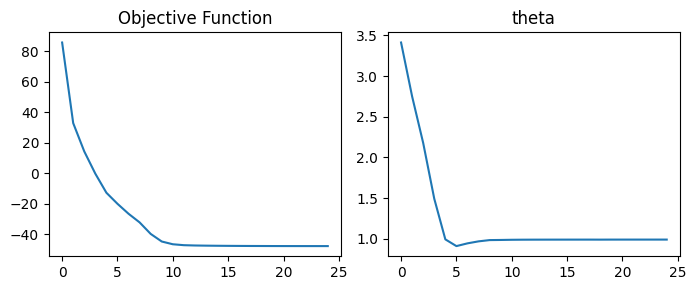

In [19]:
theta_arr = jnp.array(gp_learner.theta_list)
theta_arr = gp_learner.theta_list

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=TWO_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list) * 0.05)

plot_lc(axes[0], gp_learner.obj_list[begin_at:], "Objective Function")
plot_lc(axes[1], theta_arr[begin_at:], "theta")

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, "learningCurves.pdf"))

### Final trained parameter values

In [20]:
# extract final trained parameter values
try:
    trained_params = gp_learner.params_best.copy()
    print(f'set trained_params to gp_learner.params_best\n')
except:
    trained_params = gp_learner.params.copy()
    print(f'set trained_params to gp_learner.params\n')

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
param_save_path = os.path.join(results_save_dir, "trained_params.pkl")
with open(param_save_path, "wb") as fp:
    pickle.dump(trained_params, fp)

set trained_params to gp_learner.params_best

alpha: [17.62821142]
amp: [56.2556352]
ls: [1.43711879 0.56754069]
noise_std: [0.02987172 0.00340092 0.00101311]
theta: [0.99014535]


Can load pre-trained parameters by uncommenting the below

In [21]:
# with open(param_save_path, 'rb') as f:
    # trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [22]:
# posterior mean and covariance over test points
print(
    f"Posterior results for {GP_TYPE}, Nu={Nu}, Nf={Nf}, Ng={Ng}, Ns={test_data.Xs.shape[0]}"
)
# posterior mean and covariance over test outputs us
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)

# standard deviation of prediction at each test point
s = jnp.diag(Sigma) ** 0.5

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, "u_pred.npy"), mu)
    jnp.save(os.path.join(results_save_dir, "s_pred.npy"), s)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f"mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}")
savetxt(
    os.path.join(results_save_dir, "mean_loss.txt"), abs_losses.mean().reshape(-1, 1)
)

if RUN_INVERSE:
    theta_pred = opt_options["theta_transform"](trained_params["theta"])
    theta_loss = jnp.linalg.norm(theta_pred - THETA_TRUE)
    print(f"theta_true : {THETA_TRUE}")
    print(f"theta_pred : {theta_pred}")
    print(f"theta_loss : {theta_loss:.3e}")
    savetxt(os.path.join(results_save_dir, "theta_loss.txt"), jnp.array([theta_loss]))

Posterior results for psgp, Nu=10, Nf=10, Ng=10, Ns=8000
mean/max loss: 1.438692e-03/1.025e-02
theta_true : [1.]
theta_pred : [0.99014535]
theta_loss : 9.855e-03


### Plots of posterior prediction

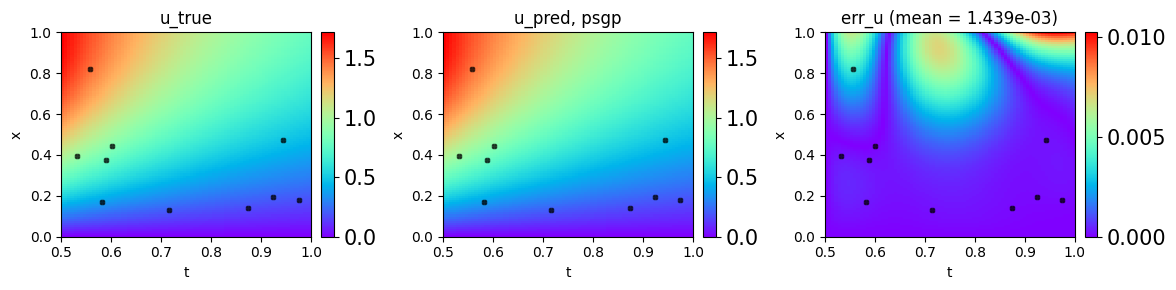

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=THREE_COLUMN_FIGSIZE)

Nx = len(jnp.unique(test_data.Xs[:, 0]))
Nt = len(jnp.unique(test_data.Xs[:, 1]))

Xu, Xf, _ = train_data.Xtrain

make_heatmap_heat = lambda ax, output, title=None: make_heatmap(
    fig, ax, output.reshape(Nt, Nx).T, test_data, Xu, Xf, title
)

make_heatmap_heat(axes[0], test_data.us, title="u_true")
make_heatmap_heat(axes[1], mu, title=f"u_pred, {GP_TYPE}")
make_heatmap_heat(axes[2], abs_losses, title=f"err_u (mean = {abs_losses.mean():.3e})")

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, "posteriorPrediction.pdf"))